# **Proposta de Trabalho 1 - Mineração de dados**

### **Professor:** Wagner Meira Jr.
### **Aluno:** Júlio César de Paula Ferreira
### **Matrícula:** 2020054609


### **Tema:** Mineração de Padrões Frequentes em Loja Online de Presentes
### **Base de dados:** (https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci)


In [ ]:
#Bibliotecas usadas no projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
!pip install mlxtend --upgrade
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 6.8 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


##**2. Data understanding (Entendimento dos dados)**


Descrição e filtragem da base de dados: Atributos, entradas, média, quantis, desvio padrão e frequências

In [ ]:
#Carregando a base de dados

In [ ]:
df = pd.read_csv('online_retail_II.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
d = df.describe().rename(columns = {'Quantity':'Quantidade','Price':'Preco'},
                         index={'count':'Número de entradas','mean':'Média','std':'Desvio Padrão','min':'Mínimo','max':'Máximo'})
d[['Quantidade','Preco']].style.format({"Quantidade":"{:20,.3f}","Preco":"{:20,.3f}"})

,Quantidade,Preco
Número de entradas,"1,067,371.000","1,067,371.000"
Média,9.939,4.649
Desvio Padrão,172.706,123.553
Mínimo,"-80,995.000","-53,594.360"
25%,1.000,1.250
50%,3.000,2.100
75%,10.000,4.150
Máximo,"80,995.000","38,970.000"


In [ ]:
df[['InvoiceDate','Country','StockCode','Description']].describe().rename(columns =
                        {'InvoiceDate':'Data da Transação','Country':'País','StockCode':'Código de Estoque','Description':'Descrição'},
                         index={'count':'Número de entradas','unique':'Únicos','top':'Maior','freq':'Frequência'})

,Data da Transação,País,Código de Estoque,Descrição
Número de entradas,1067371,1067371,1067371,1062989
Únicos,47635,43,5305,5698
Maior,2010-12-06 16:57:00,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER
Frequência,1350,981330,5829,5918


Processo de filtragem da base de dados:

- Remoção de produtos cancelados
- Remoção de produtos sem cliente registrado
- Agrupamento de produtos por compra

In [ ]:
df_noncancelled = df.loc[~df['Invoice'].str.startswith('C', na=False)]
df_noncancelled = df_noncancelled[~df_noncancelled['Customer ID'].isnull()]
df_noncancelled = df_noncancelled.groupby(['Invoice','Description'])['Quantity'].count()
df_noncancelled.to_frame()

Quantity
Invoice Description                                  
489434   WHITE CHERRY LIGHTS                        1
        15CM CHRISTMAS GLASS BALL 20 LIGHTS         1
        FANCY FONT HOME SWEET HOME DOORMAT          1
        PINK CHERRY LIGHTS                          1
        PINK DOUGHNUT TRINKET POT                   1
...                                               ...
581587  PACK OF 20 SPACEBOY NAPKINS                 1
        PLASTERS IN TIN CIRCUS PARADE               1
        PLASTERS IN TIN STRONGMAN                   1
        POSTAGE                                     1
        SPACEBOY LUNCH BOX                          1

[768619 rows x 1 columns]

Visualização de dados: Distribuição da quantidade de produtos em cada transação e histograma de produtos. Foi escolhido o quantil das 5-95% quantidades de produtos na cesta mais presentes nas transações, para eliminar outliers e cestas com muito poucos produtos.

,Quantity
Invoice,
536189,1
495754,1
495755,1
495756,1
495758,1
...,...
573576,435
578270,442
580727,529


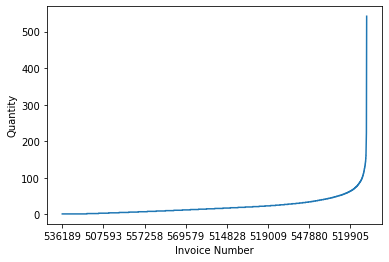

In [ ]:
df_sum = df_noncancelled.groupby('Invoice').sum()
df_sum = df_sum.sort_values()
df_sum.plot()
plt.xlabel('Invoice Number')
plt.ylabel('Quantity')
df_sum.to_frame()

15.0
65.0


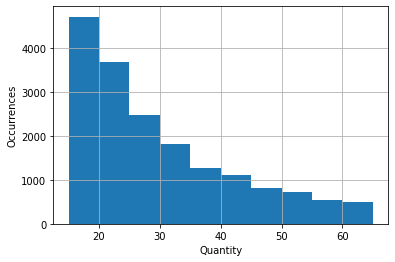

In [ ]:
min = df_sum.quantile(.5)
print(min)
maxi = df_sum.quantile(.95)
print(max)
df_sum = df_sum[df_sum>=min]
df_sum = df_sum[df_sum<=maxi]
plt.xlabel('Quantity')
plt.ylabel('Occurrences')
df_sum.hist()

##**3. Data preparation (Preparação dos dados)**

Os dados são novamente preparados removendo pedidos cancelados e sem consumidor cadastrado, também é feito o agrupamento por pedido.

Por fim, são separados em 3 categorias de dados: Dados totais, dados sazonais de páscoa e dados sazonais de natal, para diferenciar o que é comprado em datas específicas do ano.

In [ ]:
df_preparation = df.loc[~df['Invoice'].str.startswith('C', na=False)]
df_preparation = df_preparation[~df_preparation['Customer ID'].isnull()]
df_preparation = df_preparation.groupby(['Invoice','Description'])['Quantity'].count().reset_index()
df_preparation

,Invoice,Description,Quantity
0,489434,WHITE CHERRY LIGHTS,1
1,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,1
2,489434,FANCY FONT HOME SWEET HOME DOORMAT,1
3,489434,PINK CHERRY LIGHTS,1
4,489434,PINK DOUGHNUT TRINKET POT,1
...,...,...,...
768614,581587,PACK OF 20 SPACEBOY NAPKINS,1
768615,581587,PLASTERS IN TIN CIRCUS PARADE,1
768616,581587,PLASTERS IN TIN STRONGMAN,1
768617,581587,POSTAGE,1


In [ ]:
df_intermediary = df_preparation.groupby('Invoice').sum().reset_index()
df_intermediary = df_intermediary.sort_values(by="Quantity")
min = df_intermediary['Quantity'].quantile(.5)
max = df_intermediary['Quantity'].quantile(.95)
df_intermediary = df_intermediary[df_intermediary['Quantity']>=min]
df_intermediary = df_intermediary[df_intermediary['Quantity']<=max]
df_preparation = df_preparation[df_preparation['Invoice'].isin(df_intermediary['Invoice'])]
df_preparation

,Invoice,Description,Quantity
12,489436,PEACE WOODEN BLOCK LETTERS,1
13,489436,AREA PATROLLED METAL SIGN,1
14,489436,ASSORTED COLOUR BIRD ORNAMENT,1
15,489436,BATH BUILDING BLOCK WORD,1
16,489436,BISCUITS SMALL BOWL LIGHT BLUE,1
...,...,...,...
768614,581587,PACK OF 20 SPACEBOY NAPKINS,1
768615,581587,PLASTERS IN TIN CIRCUS PARADE,1
768616,581587,PLASTERS IN TIN STRONGMAN,1
768617,581587,POSTAGE,1


Principais feriados:

Páscoa (22 de Março até 25 de Abril)
Natal (18 de Dezembro até 26 de Dezembro)

Dados da Páscoa:

In [ ]:
df_preparation_easter = df.loc[~df['Invoice'].str.startswith('C', na=False)]
df_preparation_easter = df_preparation_easter[~df_preparation_easter['Customer ID'].isnull()]
df_preparation_easter['InvoiceDate'] = pd.to_datetime(df_preparation_easter['InvoiceDate'])
df_preparation_easter = df_preparation_easter[(((df_preparation_easter.InvoiceDate.dt.month==3) &(
                                               df_preparation_easter.InvoiceDate.dt.day>=22)) |
                                              ((df_preparation_easter.InvoiceDate.dt.month==4) & (
                                               df_preparation_easter.InvoiceDate.dt.day<=25)))]
df_preparation_easter = df_preparation_easter.groupby(['Invoice','Description'])['Quantity'].count().reset_index()
df_preparation_easter

,Invoice,Description,Quantity
0,501908,POLYESTER FILLER PAD 40x40cm,1
1,501909,DOOR MAT AIRMAIL,1
2,501909,DOOR MAT ENGLISH ROSE,1
3,501909,DOOR MAT FANCY FONT HOME SWEET HOME,1
4,501909,HOME SWEET HOME MUG,1
...,...,...,...
60299,550994,VICTORIAN GLASS HANGING T-LIGHT,1
60300,550994,WOOD S/3 CABINET ANT WHITE FINISH,1
60301,550994,WOODEN UNION JACK BUNTING,1
60302,550994,ZINC T-LIGHT HOLDER STAR LARGE,1


Dados do Natal:

In [ ]:
df_preparation_christmas = df.loc[~df['Invoice'].str.startswith('C', na=False)]
df_preparation_christmas = df_preparation_christmas[~df_preparation_christmas['Customer ID'].isnull()]
df_preparation_christmas['InvoiceDate'] = pd.to_datetime(df_preparation_christmas['InvoiceDate'])
df_preparation_christmas = df_preparation_christmas[((df_preparation_christmas.InvoiceDate.dt.month==12) & ((
                                               df_preparation_christmas.InvoiceDate.dt.day>=18) & df_preparation_christmas.InvoiceDate.dt.day<=26))  ]
df_preparation_christmas = df_preparation_christmas.groupby(['Invoice','Description'])['Quantity'].count().reset_index()
df_preparation_christmas

,Invoice,Description,Quantity
0,489434,WHITE CHERRY LIGHTS,1
1,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,1
2,489434,FANCY FONT HOME SWEET HOME DOORMAT,1
3,489434,PINK CHERRY LIGHTS,1
4,489434,PINK DOUGHNUT TRINKET POT,1
...,...,...,...
71785,581587,PACK OF 20 SPACEBOY NAPKINS,1
71786,581587,PLASTERS IN TIN CIRCUS PARADE,1
71787,581587,PLASTERS IN TIN STRONGMAN,1
71788,581587,POSTAGE,1


##**4. Modeling (Modelagem)**

Os dados são inicialmente transformados em uma tabela de verdadeiro e falso, que indica quando um produto aparece em determinada transação.
Em seguida, o algoritmo FPGrowth é utilizado para encontrar os padrões frequentes. O suporte utilizado foi de 1%, ou seja, um produto precisa aparecer em pelo menos 1% das transações para ser considerado.

O primeiro passo é realizado com os dados totais, em seguida é feito o mesmo com os dados de páscoa e natal

In [ ]:
te = TransactionEncoder()
df_model_total= df_preparation.groupby('Invoice')['Description'].apply(list)
te_total = te.fit(df_model_total).transform(df_model_total)
df_fp_total = pd.DataFrame(te_total, columns=te.columns_)
df_items_total = fpgrowth(df_fp_total, min_support=0.01,use_colnames=True)
df_fp_total

,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,DOLLY GIRL BEAKER,...,ZINC POLICE BOX LANTERN,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17636,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17637,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17638,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17639,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


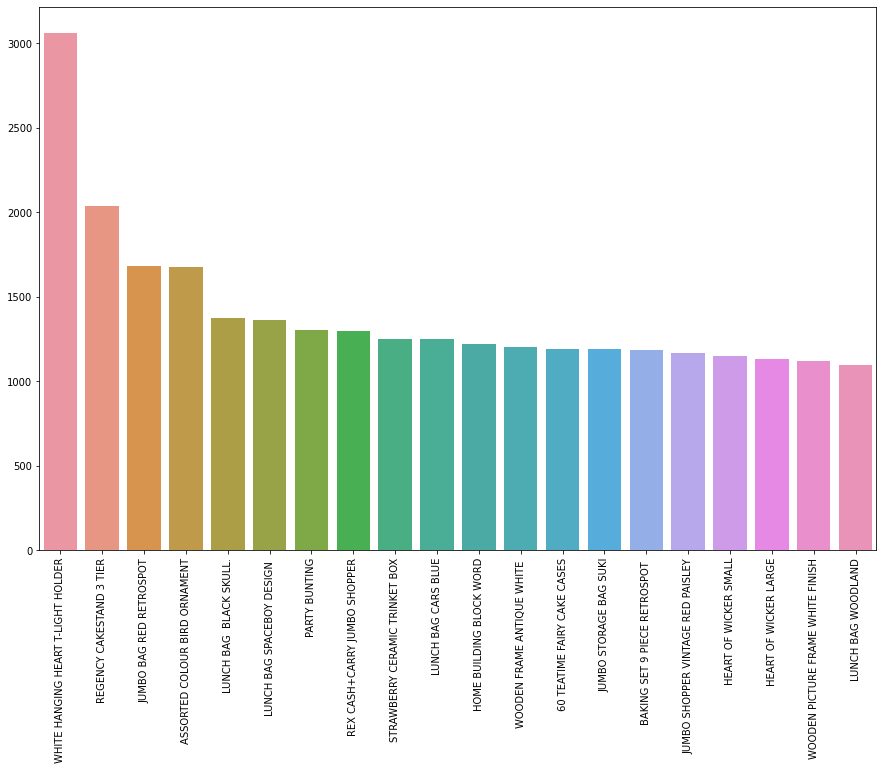

In [ ]:
chart=df_fp_total.sum(axis=0).sort_values(ascending=False)[:20]
plt.figure(figsize=(15,10))
s=sns.barplot(x=chart.index,y=chart.values)
s = s.set_xticklabels(s.get_xticklabels(), rotation=90)

In [ ]:
te = TransactionEncoder()
df_model_easter= df_preparation_easter.groupby('Invoice')['Description'].apply(list)
te_total_easter = te.fit(df_model_easter).transform(df_model_easter)
df_fp_easter = pd.DataFrame(te_total_easter, columns=te.columns_)
df_items_easter = fpgrowth(df_fp_easter, min_support=0.01,use_colnames=True)
df_fp_easter

,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,FLAMINGO LIGHTS,IVORY PAPER CUP CAKE CASES,OVAL WALL MIRROR DIAMANTE,PEACE WOODEN BLOCK LETTERS,SET 2 TEA TOWELS I LOVE LONDON,SILVER T-LIGHT SETTING,SPACEBOY BABY GIFT SET,...,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3013,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3014,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3015,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3016,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


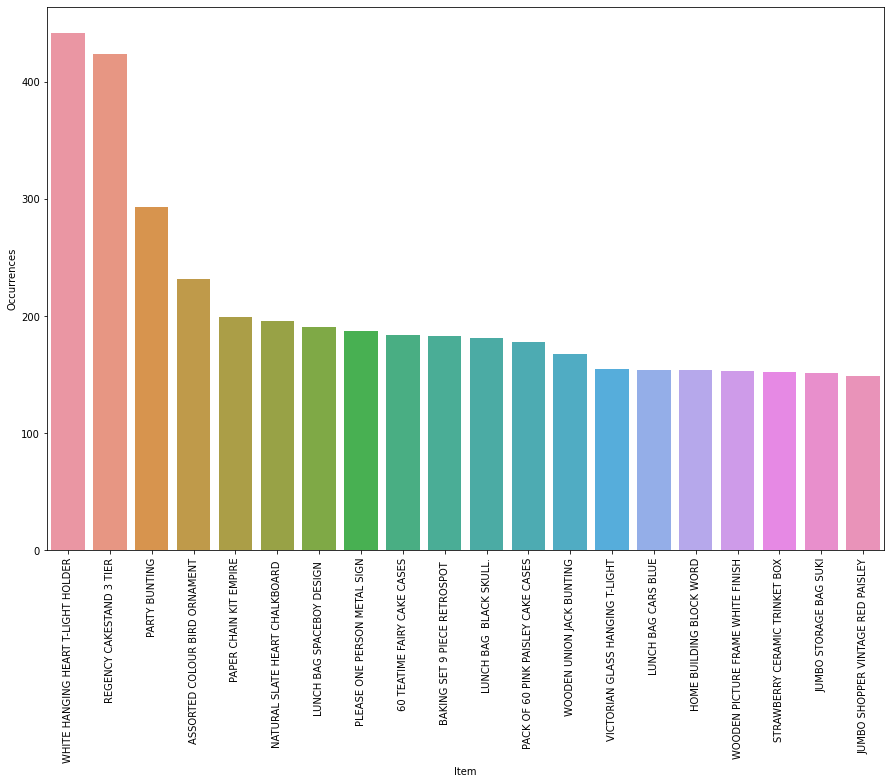

In [ ]:
chart=df_fp_easter.sum(axis=0).sort_values(ascending=False)[:20]
plt.figure(figsize=(15,10))
s=sns.barplot(x=chart.index,y=chart.values)
plt.xlabel('Item')
plt.ylabel('Occurrences')
s = s.set_xticklabels(s.get_xticklabels(), rotation=90)

In [ ]:
te = TransactionEncoder()
df_model_christmas= df_preparation_christmas.groupby('Invoice')['Description'].apply(list)
te_total_christmas = te.fit(df_model_christmas).transform(df_model_christmas)
df_fp_christmas = pd.DataFrame(te_total_christmas, columns=te.columns_)
df_items_christmas = fpgrowth(df_fp_christmas, min_support=0.01,use_colnames=True)
df_fp_christmas

,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,DOLLY GIRL BEAKER,...,ZINC METAL HEART DECORATION,ZINC POLICE BOX LANTERN,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3686,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3687,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
3688,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


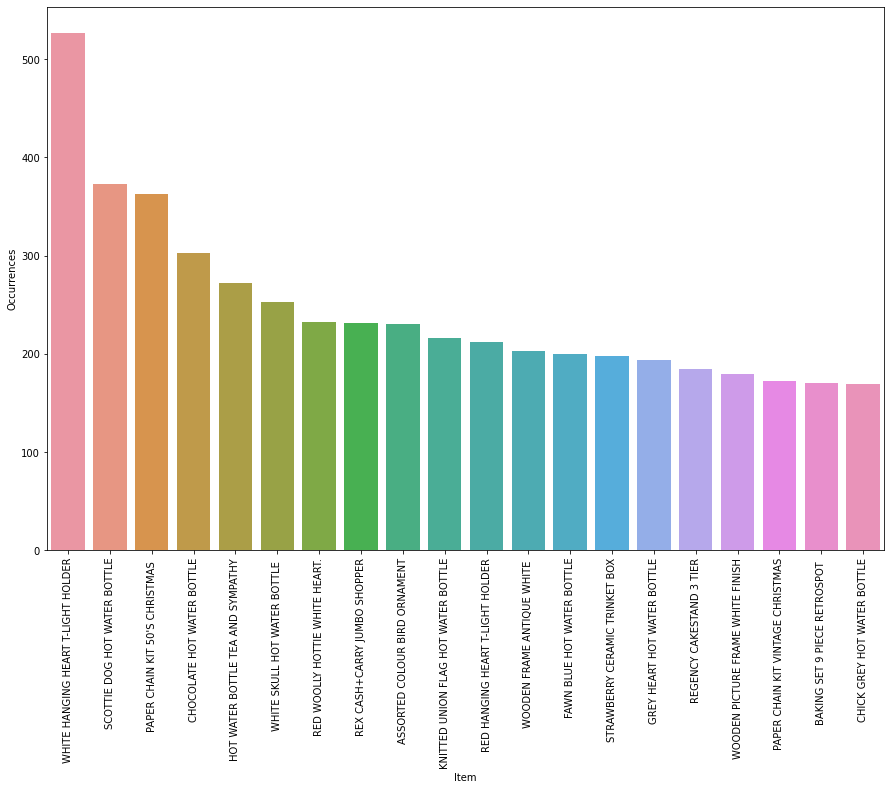

In [ ]:
chart=df_fp_christmas.sum(axis=0).sort_values(ascending=False)[:20]
plt.figure(figsize=(15,10))
s=sns.barplot(x=chart.index,y=chart.values)
plt.xlabel('Item')
plt.ylabel('Occurrences')
s = s.set_xticklabels(s.get_xticklabels(), rotation=90)

##**5. Evaluation (Validação)**


As regras de associação são utilizadas para filtrar os padrões mais importantes e que fazem sentido. A primeira filtragem trata do lift, apenas padrões com Lift maior ou igual a 1 devem ser incluídos, o que diminui o número de padrões com pouca relação.

In [ ]:
df_items_total

,support,itemsets
0,0.095176,(ASSORTED COLOUR BIRD ORNAMENT)
1,0.069157,(HOME BUILDING BLOCK WORD)
2,0.056800,(LOVE BUILDING BLOCK WORD)
3,0.053738,(SCOTTIE DOG HOT WATER BOTTLE)
4,0.027549,(HEART IVORY TRELLIS LARGE)
...,...,...
1292,0.013265,"(JUMBO BAG VINTAGE LEAF, JUMBO BAG RED RETROSPOT)"
1293,0.010374,"(JUMBO BAG VINTAGE LEAF, JUMBO BAG ALPHABET)"
1294,0.017119,"(GARDENERS KNEELING PAD KEEP CALM , GARDENERS ..."
1295,0.010487,"(LARGE WHITE HEART OF WICKER, SMALL WHITE HEAR..."


In [ ]:
rules = association_rules(df_items_total, metric="lift", min_threshold=1).sort_values(by="confidence")

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
369,(WHITE HANGING HEART T-LIGHT HOLDER),(JUMBO BAG BAROQUE BLACK WHITE),0.173686,0.053455,0.010033,0.057768,1.080677,0.000749,1.004577
125,(WHITE HANGING HEART T-LIGHT HOLDER),(CREAM SWEETHEART MINI CHEST),0.173686,0.030440,0.010033,0.057768,1.897726,0.004746,1.029003
26,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART FILIGREE DOVE LARGE),0.173686,0.022788,0.010090,0.058094,2.549344,0.006132,1.037484
127,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART FILIGREE DOVE SMALL),0.173686,0.026359,0.010090,0.058094,2.203949,0.005512,1.033692
345,(WHITE HANGING HEART T-LIGHT HOLDER),(NO SINGING METAL SIGN),0.173686,0.037753,0.010317,0.059399,1.573373,0.003760,1.023014
...,...,...,...,...,...,...,...,...,...
868,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.013661,0.037016,0.012244,0.896266,24.212895,0.011739,9.283165
852,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.020860,0.032028,0.018876,0.904891,28.253429,0.018208,10.177538
858,"(PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",(GREEN REGENCY TEACUP AND SAUCER),0.015079,0.032028,0.013661,0.906015,28.288516,0.013178,10.299226
871,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.013378,0.032028,0.012244,0.915254,28.576991,0.011816,11.422074


A visualização da confiança permite encontrar um número de padrões que tenham maior probabilidade de serem seguros para tomar decisões. Uma confiança de 60% conseguiu eliminar para o conjunto de dados um grande número de dados não confiáveis e ainda manter cerca de 20% dos dados totais

Text(0, 0.5, 'Confidence')

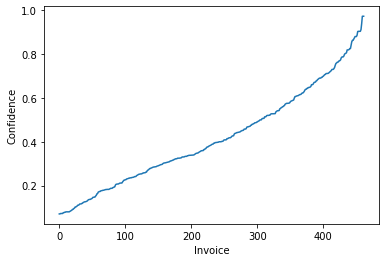

In [ ]:
rules.sort_values(by='confidence').reset_index()['confidence'].plot()
plt.xlabel('Invoice')
plt.ylabel('Confidence')

In [ ]:
filter = rules[rules.confidence>0.6]
filter = filter.reset_index()
df_items_total = df_items_total.reset_index()
df_items_total = df_items_total.merge(filter,on='index')
df_items_total

,index,support_x,itemsets,antecedents,consequents,antecedent support,consequent support,support_y,confidence,lift,leverage,conviction
0,28,0.012754,(CHARLIE+LOLA PINK HOT WATER BOTTLE),(BATH BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.020010,0.069157,0.012471,0.623229,9.011796,0.011087,2.470583
1,31,0.056459,(POSTAGE),(SMALL MARSHMALLOWS PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.014738,0.018083,0.010770,0.730769,40.412226,0.010504,3.647121
2,46,0.013775,(SET3 BOOK BOX GREEN GINGHAM FLOWER ),(PACK OF 6 SKULL PAPER PLATES),(PACK OF 6 SKULL PAPER CUPS),0.012528,0.012244,0.010033,0.800905,65.410948,0.009880,4.961228
3,47,0.011734,(RAINY LADIES BIRTHDAY CARD),(PACK OF 6 SKULL PAPER CUPS),(PACK OF 6 SKULL PAPER PLATES),0.012244,0.012528,0.010033,0.819444,65.410948,0.009880,5.469078
4,106,0.014568,(POTTERING MUG),(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.058727,0.173686,0.040474,0.689189,3.968011,0.030274,2.658575
...,...,...,...,...,...,...,...,...,...,...,...,...
162,1050,0.010997,"(WHITE HANGING HEART T-LIGHT HOLDER, COLOUR GL...",(POPPY'S PLAYHOUSE LIVINGROOM ),"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",0.015985,0.016382,0.012074,0.755319,46.105831,0.011812,4.020003
163,1130,0.010997,"(PLASTERS IN TIN STRONGMAN, PLASTERS IN TIN VI...",(JUMBO BAG SCANDINAVIAN BLUE PAISLEY),(JUMBO BAG RED RETROSPOT),0.016892,0.095516,0.010260,0.607383,6.358953,0.008647,2.303728
164,1165,0.014058,"(LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG BLACK...",(JUMBO BAG PEARS),(JUMBO BAG APPLES),0.017799,0.027663,0.011394,0.640127,23.140343,0.010902,2.701893
165,1170,0.010090,"(JUMBO BAG RED RETROSPOT, JUMBO BAG DOLLY GIRL...",(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.028456,0.023355,0.017119,0.601594,25.759012,0.016455,2.451380


In [ ]:
df_items_easter

,support,itemsets
0,0.014911,(POLYESTER FILLER PAD 40x40cm)
1,0.024851,(SAVE THE PLANET MUG)
2,0.023526,(HOME SWEET HOME MUG)
3,0.023194,(SMALL GLASS HEART TRINKET POT)
4,0.021206,(DOOR MAT ENGLISH ROSE )
...,...,...
967,0.011266,"(LUNCH BAG SUKI DESIGN , LUNCH BAG RED RETROSP..."
968,0.012591,"(LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG SPACEB..."
969,0.011928,"(LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG RED RE..."
970,0.011266,"(DOLLY GIRL LUNCH BOX, SPACEBOY LUNCH BOX )"


In [ ]:
rules = association_rules(df_items_easter, metric="lift", min_threshold=1).sort_values(by="confidence")

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
154,(WHITE HANGING HEART T-LIGHT HOLDER),(WHITE WOOD GARDEN PLANT LADDER),0.146455,0.049039,0.010272,0.070136,1.430201,0.003090,1.022688
355,(WHITE HANGING HEART T-LIGHT HOLDER),(LUNCH BAG CARS BLUE),0.146455,0.051027,0.010272,0.070136,1.374478,0.002799,1.020550
87,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART FILIGREE DOVE SMALL),0.146455,0.021206,0.010603,0.072398,3.414027,0.007497,1.055188
199,(WHITE HANGING HEART T-LIGHT HOLDER),(LOVEBIRD HANGING DECORATION WHITE ),0.146455,0.021869,0.010603,0.072398,3.310572,0.007400,1.054473
263,(WHITE HANGING HEART T-LIGHT HOLDER),(BATH BUILDING BLOCK WORD),0.146455,0.026508,0.010603,0.072398,2.731222,0.006721,1.049472
...,...,...,...,...,...,...,...,...,...
1062,"(CHILDRENS GARDEN GLOVES PINK, CHILDS GARDEN T...",(CHILDS GARDEN TROWEL PINK),0.012922,0.035785,0.012922,1.000000,27.944444,0.012460,inf
640,"(CHILDRENS GARDEN GLOVES PINK, CHILDS GARDEN F...",(CHILDS GARDEN FORK PINK),0.014911,0.031146,0.014911,1.000000,32.106383,0.014446,inf
1285,"(CHILDS GARDEN BRUSH BLUE, CHILDS GARDEN BRUSH...",(CHILDS GARDEN FORK PINK),0.010272,0.031146,0.010272,1.000000,32.106383,0.009952,inf
673,"(CHILDRENS GARDEN GLOVES PINK, CHILDS GARDEN T...",(CHILDS GARDEN FORK PINK),0.014248,0.031146,0.014248,1.000000,32.106383,0.013804,inf


Text(0, 0.5, 'Confidence')

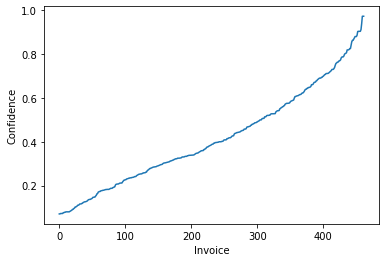

In [ ]:
rules.sort_values(by='confidence').reset_index()['confidence'].plot()
plt.xlabel('Invoice')
plt.ylabel('Confidence')

In [ ]:
filter = rules[rules.confidence>0.6]
filter = filter.reset_index()
df_items_easter = df_items_easter.reset_index()
df_items_easter = df_items_easter.merge(filter,on='index')
df_items_easter

,index,support_x,itemsets,antecedents,consequents,antecedent support,consequent support,support_y,confidence,lift,leverage,conviction
0,2,0.023526,(HOME SWEET HOME MUG),(BLUE 3 PIECE MINI DOTS CUTLERY SET),(RED 3 PIECE MINI DOTS CUTLERY SET),0.017230,0.018887,0.012260,0.711538,37.674089,0.011934,3.401193
1,3,0.023194,(SMALL GLASS HEART TRINKET POT),(RED 3 PIECE MINI DOTS CUTLERY SET),(BLUE 3 PIECE MINI DOTS CUTLERY SET),0.018887,0.017230,0.012260,0.649123,37.674089,0.011934,2.800895
2,4,0.021206,(DOOR MAT ENGLISH ROSE ),(TOILET METAL SIGN),(BATHROOM METAL SIGN),0.028164,0.030152,0.019549,0.694118,23.020297,0.018700,3.170656
3,5,0.014248,(DOOR MAT FANCY FONT HOME SWEET HOME),(BATHROOM METAL SIGN),(TOILET METAL SIGN),0.030152,0.028164,0.019549,0.648352,23.020297,0.018700,2.763658
4,7,0.044069,(GUMBALL COAT RACK),(KITCHEN METAL SIGN),(TOILET METAL SIGN),0.019549,0.028164,0.014579,0.745763,26.478963,0.014029,3.822554
...,...,...,...,...,...,...,...,...,...,...,...,...
337,964,0.011928,"(LUNCH BAG SPACEBOY DESIGN , LUNCH BAG PINK PO...","(CHILDRENS GARDEN GLOVES PINK, CHILDS GARDEN F...","(CHILDS GARDEN FORK PINK, CHILDRENS GARDEN GLO...",0.014911,0.015242,0.013585,0.911111,59.776812,0.013358,11.078529
338,965,0.010272,"(LUNCH BAG WOODLAND, LUNCH BAG PINK POLKADOT)","(CHILDRENS GARDEN GLOVES BLUE, CHILDS GARDEN F...","(CHILDS GARDEN FORK PINK, CHILDRENS GARDEN GLO...",0.014911,0.017893,0.013585,0.911111,50.920988,0.013318,11.048708
339,968,0.012591,"(LUNCH BAG DOLLY GIRL DESIGN, LUNCH BAG SPACEB...",(CHILDRENS GARDEN GLOVES BLUE),"(CHILDS GARDEN FORK PINK, CHILDRENS GARDEN GLO...",0.021537,0.014911,0.013585,0.630769,42.303590,0.013264,2.667951
340,970,0.011266,"(DOLLY GIRL LUNCH BOX, SPACEBOY LUNCH BOX )","(CHILDS GARDEN TROWEL PINK, CHILDRENS GARDEN G...",(CHILDS GARDEN FORK BLUE ),0.015905,0.027502,0.013254,0.833333,30.301205,0.012816,5.834990


In [ ]:
df_items_christmas

,support,itemsets
0,0.053659,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.026829,( WHITE CHERRY LIGHTS)
2,0.026016,(SAVE THE PLANET MUG)
3,0.021951,(PINK CHERRY LIGHTS)
4,0.018428,(15CM CHRISTMAS GLASS BALL 20 LIGHTS)
...,...,...
632,0.010569,"(SET OF 20 VINTAGE CHRISTMAS NAPKINS, PAPER CH..."
633,0.010027,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC..."
634,0.010027,"(PLASTERS IN TIN CIRCUS PARADE , PLASTERS IN T..."
635,0.011111,"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE..."


In [ ]:
rules = association_rules(df_items_christmas, metric="lift", min_threshold=1).sort_values(by="confidence")

Text(0, 0.5, 'Confidence')

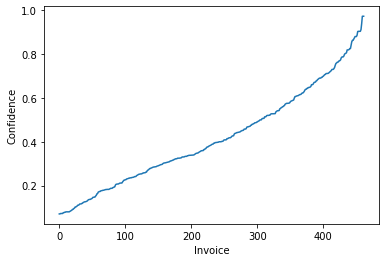

In [ ]:
rules.sort_values(by='confidence').reset_index()['confidence'].plot()
plt.xlabel('Invoice')
plt.ylabel('Confidence')

In [ ]:
filter = rules[rules.confidence>0.6]
filter = filter.reset_index()
df_items_christmas = df_items_christmas.reset_index()
df_items_christmas = df_items_christmas.merge(filter,on='index')
df_items_christmas

,index,support_x,itemsets,antecedents,consequents,antecedent support,consequent support,support_y,confidence,lift,leverage,conviction
0,7,0.010027,"(RECORD FRAME 7"" SINGLE SIZE )",(PINK CHERRY LIGHTS),( WHITE CHERRY LIGHTS),0.021951,0.026829,0.014905,0.679012,25.308642,0.014316,3.031801
1,27,0.015989,(FELTCRAFT DOLL ROSIE),(CHARLIE+LOLA PINK HOT WATER BOTTLE),(CHARLIE + LOLA RED HOT WATER BOTTLE),0.022764,0.026558,0.013821,0.607143,22.860787,0.013217,2.477852
2,30,0.026558,(CHARLIE + LOLA RED HOT WATER BOTTLE),(BLACK/BLUE DOTS RUFFLED UMBRELLA),(RED/WHITE DOTS RUFFLED UMBRELLA),0.017886,0.023848,0.014092,0.787879,33.037190,0.013666,4.601858
3,62,0.013821,(LOVEBIRD HANGING DECORATION WHITE ),(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.057453,0.142818,0.040921,0.712264,4.987201,0.032716,2.979057
4,93,0.011382,(WHITE SPOT BLUE CERAMIC DRAWER KNOB),"(WOODEN FRAME ANTIQUE WHITE , WOOD 2 DRAWER CA...",(WHITE HANGING HEART T-LIGHT HOLDER),0.019783,0.142818,0.012466,0.630137,4.412155,0.009641,2.317565
...,...,...,...,...,...,...,...,...,...,...,...,...
101,457,0.014363,(RED RETROSPOT CHARLOTTE BAG),(PLASTERS IN TIN STRONGMAN),(PLASTERS IN TIN CIRCUS PARADE ),0.015447,0.018970,0.010027,0.649123,34.218045,0.009734,2.795935
102,458,0.012737,(TRADITIONAL KNITTING NANCY),(POPPY'S PLAYHOUSE BEDROOM ),(POPPY'S PLAYHOUSE LIVINGROOM ),0.015447,0.013550,0.011111,0.719298,53.084211,0.010902,3.514228
103,459,0.012195,(LARGE PURPLE BABUSHKA NOTEBOOK ),(POPPY'S PLAYHOUSE LIVINGROOM ),(POPPY'S PLAYHOUSE BEDROOM ),0.013550,0.015447,0.011111,0.820000,53.084211,0.010902,5.469738
104,460,0.010569,(HAPPY STENCIL CRAFT),(POPPY'S PLAYHOUSE LIVINGROOM ),(POPPY'S PLAYHOUSE KITCHEN),0.013550,0.016260,0.011111,0.820000,50.430000,0.010891,5.465221
